In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# Set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

In [3]:
# make a directory for figures
!mkdir -p figs

In [4]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

In [5]:
download('https://snap.stanford.edu/data/facebook_combined.txt.gz')

Downloaded facebook_combined.txt.gz


In [6]:
fb = read_graph('facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

In [7]:
from networkx.algorithms.approximation import average_clustering

In [8]:
def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
               for pair in pairs]
    return lengths

In [9]:
def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

In [10]:
C = average_clustering(fb)
C

0.6

In [11]:
L = estimate_path_length(fb)
L

3.717

In [12]:
n = len(fb)
m = len(fb.edges())
k = int(round(2*m/n))
k

44

In [13]:
lattice = nx.watts_strogatz_graph(n, k, p=0)
len(lattice), len(lattice.edges())

(4039, 88858)

In [14]:
C, average_clustering(lattice)

(0.6, 0.705)

In [15]:
L, estimate_path_length(lattice)

(3.717, 47.088)

In [16]:
random_graph = nx.watts_strogatz_graph(n, k, p=1)

In [17]:
C, average_clustering(random_graph)

(0.6, 0.012)

In [18]:
L, estimate_path_length(random_graph)

(3.717, 2.609)

In [19]:
ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)

In [20]:
C, average_clustering(ws)

(0.6, 0.636)

In [21]:
L, estimate_path_length(ws)

(3.717, 3.264)

In [22]:
def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]

In [23]:
np.mean(degrees(fb)), np.mean(degrees(ws))

(43.69101262688784, 44.0)

In [24]:
np.std(degrees(fb)), np.std(degrees(ws))

(52.41411556737521, 1.4309215628189869)

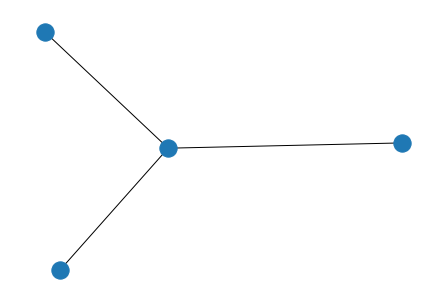

In [25]:
G = nx.Graph()
G.add_edge(1, 0)
G.add_edge(2, 0)
G.add_edge(3, 0)
nx.draw(G)

In [26]:
degrees(G)

[1, 3, 1, 1]

In [27]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.6.2-py3-none-any.whl size=10737 sha256=f06761168def8f66065483d4163ed456687ececb237b08d422346afa09a12e8c
  Stored in directory: /Users/dianagrass/Library/Caches/pip/wheels/18/e0/a6/839fd86a0ceef3dff1f5b6fded43422d9da39b4d8c32bf4c3b
Successfully built empiricaldist


In [28]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(degrees(G))
pmf

,probs
1,0.75
3,0.25


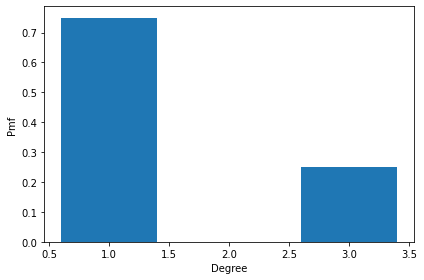

In [29]:
pmf.bar()
decorate(xlabel='Degree',
         ylabel='Pmf')

In [30]:
pmf_fb = Pmf.from_seq(degrees(fb))
pmf_fb.mean(), pmf_fb.std()

(43.69101262688785, 52.41411556737521)

In [31]:
pmf_ws = Pmf.from_seq(degrees(ws))
pmf_ws.mean(), pmf_ws.std()

(44.00000000000001, 1.4309215628189869)

In [32]:
pmf_ws = Pmf.from_seq(degrees(ws))
pmf_ws.mean(), pmf_ws.std()

(44.00000000000001, 1.4309215628189869)

In [33]:
pmf_fb(1), pmf_ws(1)

(0.018568952711067097, 0)

Saving figure to file figs/chap04-1


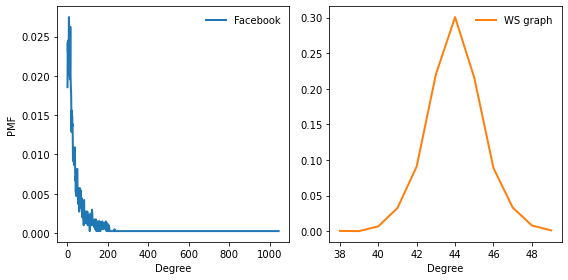

In [34]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_ws.plot(label='WS graph', color='C1')
decorate(xlabel='Degree')

savefig('figs/chap04-1')

Saving figure to file figs/chap04-2


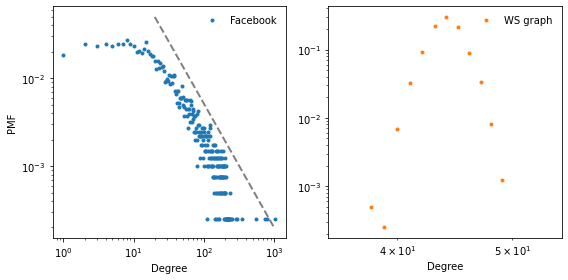

In [35]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)
plt.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')

pmf_fb.plot(label='Facebook', color='C0', **options)
decorate(xscale='log', yscale='log',
         xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_ws.plot(label='WS graph', color='C1', **options)
decorate(xlim=[35, 55], 
         xscale='log', yscale='log',
         xlabel='Degree')

savefig('figs/chap04-2')

In [36]:
import random

def barabasi_albert_graph(n, k, seed=None):
    """Constructs a BA graph.
    
    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

In [37]:
def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.
    
    repeated_nodes: list of nodes
    k: size of set
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

In [38]:
n = len(fb)
m = len(fb.edges())
k = int(round(m/n))
n, m, k

(4039, 88234, 22)

In [39]:
ba = barabasi_albert_graph(n, k, seed=15)

In [40]:
len(ba), len(ba.edges()), len(ba.edges())/len(ba)

(4039, 88374, 21.88016835850458)

In [41]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.69101262688784, 43.76033671700916)

In [42]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.41411556737521, 41.03760075705614)

In [43]:
pmf_ba = Pmf.from_seq(degrees(ba))

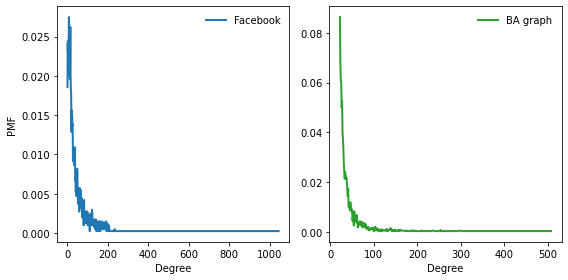

In [44]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_ba.plot(label='BA graph', color='C2')
decorate(xlabel='Degree')

Saving figure to file figs/chap04-3


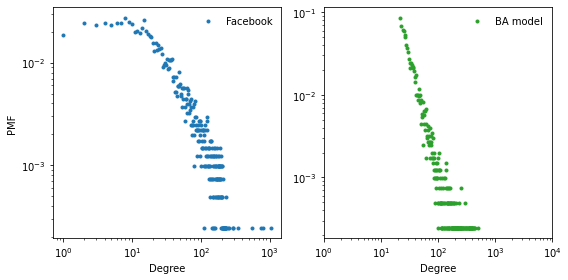

In [45]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)

pmf_fb.plot(label='Facebook', color='C0', **options)
decorate(xlabel='Degree', ylabel='PMF',
         xscale='log', yscale='log')

plt.subplot(1,2,2)

pmf_ba.plot(label='BA model', color='C2', **options)
decorate(xlabel='Degree',
         xlim=[1, 1e4],
         xscale='log', yscale='log')

savefig('figs/chap04-3')

In [46]:
L, estimate_path_length(ba)

(3.717, 2.481)

In [47]:
C, average_clustering(ba)

(0.6, 0.048)

In [48]:
def cumulative_prob(pmf, x):
    """Computes the cumulative probability of `x`.
    
    Total probability of all values <= x.
    
    returns: float probability
    """
    ps = [pmf[value] for value in pmf.qs if value<=x]
    return np.sum(ps)

In [49]:
cumulative_prob(pmf_fb, 11)

0.2577370636296113

In [50]:
cumulative_prob(pmf_fb, 25)

0.5060658578856152

In [51]:
cumulative_prob(pmf_fb, 57)

0.751671205743996

In [52]:
from empiricaldist import Cdf